<h1>I. Import library and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, make_scorer

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [4]:
data = pd.read_csv(r"C:\Users\PC\Downloads\insurance_claims.csv")

In [5]:
data.replace('?', np.nan, inplace=True)

In [6]:
data.drop(['_c39'],axis=1,inplace=True)

In [7]:
data.drop(['policy_number'],axis=1,inplace=True)

In [8]:
data.drop(data[data['umbrella_limit'] < 0].index, inplace=True)

<h1>II. Approach 

<h2>1. Preprocessing 

Other preprocessing steps, such as handling missing values, managing outliers, and encoding categorical variables, follow the same approach as in Mini Project 5. However, scaling and resampling are applied selectively, based on their impact on model performance. Various combinations of scaling, resampling, and other preprocessing methods are tested, and only the most effective approaches are retained for this notebook. This ensures that the preprocessing pipeline is optimized for the dataset and model requirements.

<h3>1.1. Scaling 

Scaling is generally recommended before applying PCA (Principal Component Analysis) because it ensures that all features contribute equally to the analysis by standardizing their scales. However, in this notebook, scaling is not always applied. For some models, skipping scaling has shown better performance, particularly when the natural scale of features carries meaningful information. Additionally, tree-based models, such as decision trees and random forests, inherently handle features with different scales effectively and do not require scaling. This flexible approach allows for adapting to the specific needs of different models and datasets.

<h3>1.2. Resampling

To address class imbalance, three resampling techniques are utilized: undersampTo address class imbalance, three resampling techniques are explored: **undersampling** with Tomek Links, **oversampling** using SMOTE (Synthetic Minority Oversampling Technique), and a hybrid approach that combines both methods (SMOTE-Tomek). Additionally, the `class_weight='balanced'` parameter is considered as an alternative strategy. The application of these techniques depends on their impact on model performance, with the most effective approach being selected based on evaluation metrics. This ensures that the chosen method aligns with the dataset's characteristics and optimizes the model's ability to handle imbalanced data.ling using Tomek Links, oversampling with SMOTE (Synthetic Minority Oversampling Technique), and a hybrid approach that combines both methods (SMOTE-Tomek). Additionally, setting class_weight='balanced' is explored as an alternative approach. Applied or not depends on the performance of it when applied. 

<h2>2. PCA

The optimal number of PCA components is determined by evaluating model performance based on the F1 score. Each potential number of components is used to fit PCA, and the resulting components are passed to the model for training and cross-validation. The F1 scores for all tested component values are calculated and visualized in a plot. The optimal number of components is chosen as the one that achieves the highest F1 score, ensuring the best balance between dimensionality reduction and predictive performance.

<h2>3. Metrics 

To address these challenges, the F1 score has been chosen as the primary evaluation metric, similar to the approach in Mini Project 6. The F1 score, which represents the harmonic mean of precision and recall, is ideal for balancing the trade-off between these two metrics. While recall is also considered a crucial secondary criterion, prioritizing the F1 score ensures the model achieves a balanced performance. This strategy allows for the effective identification of fraudulent transactions while keeping the false positive rate under control, striking a balance between cost-efficiency and reliable fraud detection.

<h1>III. EDA

In [9]:
threshold = 0.697
correlated_features = set()

correlation_matrix = pd.DataFrame(X).corr()

for i in range(correlation_matrix.shape[0]):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_features.add(correlation_matrix.columns[i])

print(f"Highly Correlated Features: {correlated_features}")

NameError: name 'X' is not defined

The dataset contains 241 features, with only 31 highly correlated features identified at a correlation threshold of 0.697. This indicates low multicollinearity among the features. Given the low redundancy, applying PCA is unlikely to provide significant dimensionality reduction or performance improvements in this case.

<h1>IV. Preprocessing 

<h2>1. Transforming data

In [10]:
data['policy_bind_date'] = pd.to_datetime(data['policy_bind_date'])
data['incident_date'] = pd.to_datetime(data['incident_date'])

data['policy_bind_year'] = data['policy_bind_date'].dt.year
data['policy_bind_month'] = data['policy_bind_date'].dt.month
data['policy_bind_day'] = data['policy_bind_date'].dt.day

data['incident_year'] = data['incident_date'].dt.year
data['incident_month'] = data['incident_date'].dt.month
data['incident_day'] = data['incident_date'].dt.day

columns_to_drop = ['policy_bind_date', 'incident_date']
data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [11]:
data[['policy_csl_1', 'policy_csl_2']] = data['policy_csl'].str.split('/', expand=True)
data.drop(['policy_csl'], axis=1, inplace=True)

In [12]:
data[['incident_number', 'incident_road']] = data['incident_location'].str.extract(r'(\d+)\s(.+)') 
data_number = data[['incident_number']]
data_road = data[['incident_road']]
data_split = pd.concat([data_number, data_road], ignore_index=True)

data.drop('incident_location', axis=1, inplace=True)

In [13]:
data['policy_csl_1'] = data['policy_csl_1'].astype(int)
data['policy_csl_2'] = data['policy_csl_2'].astype(int)
data['incident_number'] = data['incident_number'].astype(int)

<h2>2 .Feature engineering 

In [14]:
claim_threshold = 10000
multiple_claims_threshold = 15000
deductible_threshold = 500
current_year = 2024
auto_age_threshold = 10

data['high_claim_amount'] = (data['total_claim_amount'] > claim_threshold).astype(int)
data['multiple_claims'] = ((data['injury_claim'] + data['property_claim'] + data['vehicle_claim']) > multiple_claims_threshold).astype(int)
data['high_deductible'] = (data['policy_deductable'] > deductible_threshold).astype(int)
data['risky_auto_age'] = ((current_year - data['auto_year']) > auto_age_threshold).astype(int)
data['customer_income_level'] = data['capital-gains'] - data['capital-loss']

<h2>3. Imputing missing value

In [15]:
imputer = SimpleImputer(strategy='most_frequent')
data[['property_damage', 'police_report_available', 'collision_type', 'authorities_contacted']] =imputer.fit_transform(data[['property_damage', 'police_report_available', 'collision_type', 'authorities_contacted']])
data

,months_as_customer,age,policy_state,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,policy_bind_year,policy_bind_month,policy_bind_day,incident_year,incident_month,incident_day,policy_csl_1,policy_csl_2,incident_number,incident_road,high_claim_amount,multiple_claims,high_deductible,risky_auto_age,customer_income_level
0,328,48,OH,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,2014,10,17,2015,1,25,250,500,9935,4th Drive,1,1,1,1,53300
1,228,42,IN,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,Rear Collision,Minor Damage,Police,VA,Riverwood,8,1,NO,0,0,NO,5070,780,780,3510,Mercedes,E400,2007,Y,2006,6,27,2015,1,21,250,500,6608,MLK Hwy,0,0,1,1,0
2,134,29,OH,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,2000,9,6,2015,2,22,100,300,7121,Francis Lane,1,1,1,1,35100
3,256,41,IL,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,5,1,NO,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,1990,5,25,2015,1,10,250,500,6956,Maple Drive,1,1,1,0,111300
4,228,44,IL,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,Vehicle Theft,Rear Collision,Minor Damage,Police,NY,Arlington,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,2014,6,6,2015,2,17,500,1000,3041,3rd Ave,0,0,1,1,112000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,OH,1000,1310.80,0,431289,FEMALE,Masters,craft-repair,paintball,unmarried,0,0,Single Vehicle Collision,Front Collision,Minor Damage,Fire,NC,Northbrook,20,1,YES,0,1,NO,87200,17440,8720,61040,Honda,Accord,2006,N,1991,7,16,2015,2,22,500,1000,6045,Andromedia St,1,1,1,1,0
996,285,41,IL,1000,1436.79,0,608177,FEMALE,PhD,prof-specialty,sleeping,wife,70900,0,Single Vehicle Collision,Rear Collision,Major Damage,Fire,SC,Northbend,23,1,YES,2,3,NO,108480,18080,18080,72320,Volkswagen,Passat,2015,N,2014,1,5,2015,1,24,100,300,3092,Texas Drive,1,1,1,0,70900
997,130,34,OH,500,1383.49,3000000,442797,FEMALE,Masters,armed-forces,bungie-jumping,other-relative,35100,0,Multi-vehicle Collision,Side Collision,Minor Damage,Police,NC,Arlington,4,3,NO,2,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,2003,2,17,2015,1,23,250,500,7629,5th St,1,1,0,1,35100
998,458,62,IL,2000,1356.92,5000000,441714,MALE,Associate,handlers-cleaners,base-jumping,wife,0,0,Single Vehicle Collision,Rear Collision,Major Damage,Other,NY,Arlington,2,1,NO,0,1,YES,46980,5220,5220,36540,Audi,A5,1998,N,2011,11,18,2015,2,26,500,1000,6128,Elm Lane,1,1,1,1,0


In [16]:
X = data.drop(columns=['fraud_reported'])
y = data['fraud_reported']

<h2>4. Encoding 

In [17]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.frequency_dict = {}
        for column in X.columns:
            self.frequency_dict[column] = X[column].value_counts().to_dict()
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        for column in X.columns:
            X_transformed[column] = X[column].map(self.frequency_dict[column])
        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else self.frequency_dict.keys()

one_hot_columns = [
    'policy_state', 'insured_hobbies', 'insured_relationship', 
    'incident_type', 'authorities_contacted', 'collision_type',
    'incident_state', 'incident_city', 'incident_road', 
]
frequency_columns = ['auto_make', 'auto_model', 'insured_occupation']
ordinal_columns = ['insured_sex', 'property_damage', 'police_report_available']
custom_ordinal_columns = ['insured_education_level', 'incident_severity']

ordinal_categories = [
    ['FEMALE', 'MALE'], 
    ['NO', 'YES'],     
    ['NO', 'YES']        
]

custom_ordinal_categories = [
    ['MD', 'PhD', 'Associate', 'Masters', 'High School', 'College', 'JD'], 
    ['Major Damage', 'Minor Damage', 'Total Loss', 'Trivial Damage']       
]

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), one_hot_columns),
        ('frequency', FrequencyEncoder(), frequency_columns),
        ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_columns),
        ('custom_ordinal', OrdinalEncoder(categories=custom_ordinal_categories), custom_ordinal_columns)
    ]
)

X_encoded = preprocessor.fit_transform(X)

X = pd.DataFrame(X_encoded, index=X.index)

In [18]:
y = data['fraud_reported'].map({'Y': 1, 'N': 0}) 

<h2>5. Train, test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2>6. Cross validation

In [20]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)

<h1>V. Model

<h2>1. Logistic Regression

<h3>1.1. Baseline model

In [33]:
model = LogisticRegression(random_state=42)

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

cv_results = cross_validate(
    estimator=model,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,
    n_jobs=-1 
)

f1_mean = cv_results['test_f1_weighted'].mean()
recall_mean = cv_results['test_recall_weighted'].mean()
precision_mean = cv_results['test_precision_weighted'].mean()
accuracy_mean = cv_results['test_accuracy'].mean()

print("Cross-Validated Mean Scores:")
print(f"F1 Score (Weighted, CV Mean): {f1_mean:.4f}")
print(f"Recall (Weighted, CV Mean): {recall_mean:.4f}")
print(f"Precision (Weighted, CV Mean): {precision_mean:.4f}")
print(f"Accuracy (CV Mean): {accuracy_mean:.4f}")

Cross-Validated Mean Scores:
F1 Score (Weighted, CV Mean): 0.8270
Recall (Weighted, CV Mean): 0.8348
Precision (Weighted, CV Mean): 0.8268
Accuracy (CV Mean): 0.8348


<h3>1.2. Baseline model with class weight = 'balanced'

In [34]:
model = LogisticRegression(random_state=42, class_weight='balanced')

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

cv_results = cross_validate(
    estimator=model,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,
    n_jobs=-1 
)

f1_mean = cv_results['test_f1_weighted'].mean()
recall_mean = cv_results['test_recall_weighted'].mean()
precision_mean = cv_results['test_precision_weighted'].mean()   
accuracy_mean = cv_results['test_accuracy'].mean()

print("Cross-Validated Mean Scores:")
print(f"F1 Score (Weighted, CV Mean): {f1_mean:.4f}")
print(f"Recall (Weighted, CV Mean): {recall_mean:.4f}")
print(f"Precision (Weighted, CV Mean): {precision_mean:.4f}")
print(f"Accuracy (CV Mean): {accuracy_mean:.4f}")

Cross-Validated Mean Scores:
F1 Score (Weighted, CV Mean): 0.8462
Recall (Weighted, CV Mean): 0.8398
Precision (Weighted, CV Mean): 0.8635
Accuracy (CV Mean): 0.8398


The results show that using `class_weight='balanced'` outperforms resampling techniques in addressing the class imbalance within the dataset.

<h3>1.3 Applying PCA 

The model's performance is evaluated across different numbers of components, and the optimal number of components is identified by maximizing the mean F1 score through cross-validation

Best Number of Components: 207
Highest Mean CV F1 Score: 0.7824807805652393


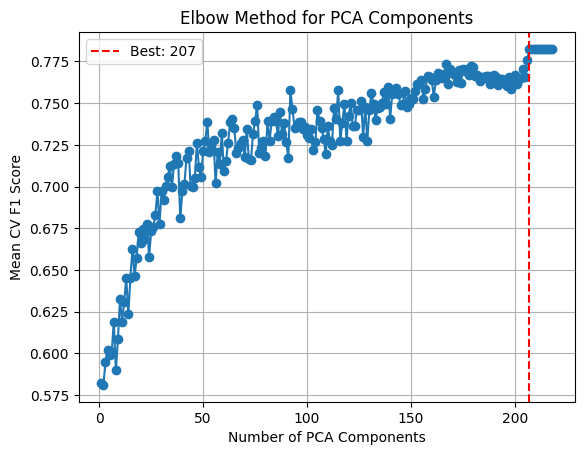

In [77]:
n_components = range(1, X_train.shape[1] + 1) 
f1_scores = []

for n in n_components:
    pipeline = Pipeline([ 
        ('scaler', StandardScaler()),            
        ('pca', PCA(n_components=n, random_state=42)),         
        ('model', LogisticRegression(random_state=42, class_weight='balanced'))  
    ])

    scoring = {
        'f1_weighted': make_scorer(f1_score, average='weighted'),
    }

    cv_results = cross_validate(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=False,
        n_jobs=-1
    )

    f1_mean = cv_results['test_f1_weighted'].mean()
    f1_scores.append(f1_mean)

best_n_components_index = np.argmax(f1_scores)
best_n_components = n_components[best_n_components_index]
best_f1 = f1_scores[best_n_components_index]

print(f"Best Number of Components: {best_n_components}")
print(f"Highest Mean CV F1 Score: {best_f1}")

plt.plot(n_components, f1_scores, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean CV F1 Score')
plt.title('Elbow Method for PCA Components')
plt.axvline(x=best_n_components, color='r', linestyle='--', label=f'Best: {best_n_components}')
plt.legend()
plt.grid()
plt.show()

In [78]:
pipeline = Pipeline([ 
    ('scaler', StandardScaler()),            
    ('pca', PCA(random_state=42, n_components=207)),         
    ('model', LogisticRegression(random_state=42, class_weight='balanced'))  
])

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

cv_results = cross_validate(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,
    n_jobs=-1
)

pca = PCA(random_state=42, n_components=0.99)
pca.fit(StandardScaler().fit_transform(X_train))  
n_features_retained = pca.n_components_

f1_mean = cv_results['test_f1_weighted'].mean()
recall_mean = cv_results['test_recall_weighted'].mean()
precision_mean = cv_results['test_precision_weighted'].mean()
accuracy_mean = cv_results['test_accuracy'].mean()

print("Cross-Validated Mean Scores:")
print(f"F1 Score (Weighted, CV Mean): {f1_mean:.4f}")
print(f"Recall (Weighted, CV Mean): {recall_mean:.4f}")
print(f"Precision (Weighted, CV Mean): {precision_mean:.4f}")
print(f"Accuracy (CV Mean): {accuracy_mean:.4f}")
print(f"Number of features retained to explain 99% variance: {n_features_retained}")


Cross-Validated Mean Scores:
F1 Score (Weighted, CV Mean): 0.7825
Recall (Weighted, CV Mean): 0.7797
Precision (Weighted, CV Mean): 0.7871
Accuracy (CV Mean): 0.7797
Number of features retained to explain 99% variance: 202


Among the tested numbers of components, the highest mean CV F1 score is achieved with 207 components. This indicates that nearly all the information in the dataset is preserved, with only a small fraction of features excluded. However, a trade-off exists: retaining 207 components minimizes information loss but keeps a relatively large number of features, leading to higher computational costs and potentially overfitting if noise is retained. Conversely, reducing the number of components further could simplify the model and speed up computation but risks losing critical information, which may degrade performance.

<h3>1.4 Hyperparameter tuning 

In [79]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),            
    ('pca', PCA(random_state=42, n_components=207)),         
    ('model', LogisticRegression(random_state=42, class_weight='balanced'))
])

param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],   
    'model__solver': ['liblinear', 'lbfgs'], 
    'model__penalty': ['l1', 'l2']          
}

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,  
    n_jobs=-1,
    verbose=1,
    refit='f1_weighted'  
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Weighted F1 Score:", grid_search.best_score_)

mean_cv_recall = grid_search.cv_results_['mean_test_recall_weighted'][grid_search.best_index_]
mean_cv_precision = grid_search.cv_results_['mean_test_precision_weighted'][grid_search.best_index_]
mean_cv_accuracy = grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]

print(f"Mean CV Recall: {mean_cv_recall:.4f}")
print(f"Mean CV Precision: {mean_cv_precision:.4f}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.4f}")

best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

print(f"F1 Score on Test Set: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall on Test Set: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Precision on Test Set: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred):.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best Weighted F1 Score: 0.7900999902134135
Mean CV Recall: 0.7848
Mean CV Precision: 0.7992
Mean CV Accuracy: 0.7848
F1 Score on Test Set: 0.7731
Recall on Test Set: 0.7700
Precision on Test Set: 0.7768
Accuracy on Test Set: 0.7700


After tuning, this is the best performance the model has achieved.

<h2>2. Decision Tree 

<h3>2.1. Baseline model with class weight = balanced 

In [38]:
model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

cv_results = cross_validate(
    estimator=model,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,
    n_jobs=-1 
)

f1_mean = cv_results['test_f1_weighted'].mean()
recall_mean = cv_results['test_recall_weighted'].mean()
precision_mean = cv_results['test_precision_weighted'].mean()
accuracy_mean = cv_results['test_accuracy'].mean()

print("Cross-Validated Mean Scores:")
print(f"F1 Score (Weighted, CV Mean): {f1_mean:.4f}")
print(f"Recall (Weighted, CV Mean): {recall_mean:.4f}")
print(f"Precision (Weighted, CV Mean): {precision_mean:.4f}")
print(f"Accuracy (CV Mean): {accuracy_mean:.4f}")

Cross-Validated Mean Scores:
F1 Score (Weighted, CV Mean): 0.8127
Recall (Weighted, CV Mean): 0.8085
Precision (Weighted, CV Mean): 0.8218
Accuracy (CV Mean): 0.8085


<h3>2.2 Applying PCA 

Best Number of Components: 152
Highest Mean CV F1 Score: 0.8166167273699226


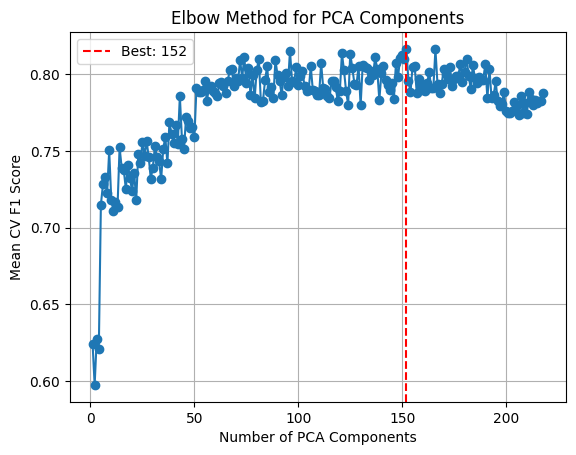

In [82]:
n_components = range(1, X_train.shape[1] + 1) 

for n in n_components:
    pipeline = Pipeline([ 
        ('pca', PCA(n_components=n, random_state=42)),         
        ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
    ])

    scoring = {
        'f1_weighted': make_scorer(f1_score, average='weighted'),
    }

    cv_results = cross_validate(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=False,
        n_jobs=-1
    )

    f1_mean = cv_results['test_f1_weighted'].mean()
    f1_scores.append(f1_mean)

best_n_components_index = np.argmax(f1_scores)
best_n_components = n_components[best_n_components_index]
best_f1 = f1_scores[best_n_components_index]

print(f"Best Number of Components: {best_n_components}")
print(f"Highest Mean CV F1 Score: {best_f1}")

import matplotlib.pyplot as plt

plt.plot(n_components, f1_scores, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean CV F1 Score')
plt.title('Elbow Method for PCA Components')
plt.axvline(x=best_n_components, color='r', linestyle='--', label=f'Best: {best_n_components}')
plt.legend()
plt.grid()
plt.show()

<h3>2.3. Hyperparameter tuning 

In [83]:
pipeline = Pipeline([
    ('pca', PCA(random_state=42, n_components=152)),
    ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

param_grid = { 
    'model__max_depth': [3, 5, 10, None], 
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4], 
    'model__criterion': ['gini', 'entropy']  
}

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    cv=5, 
    n_jobs=-1,  
    verbose=1,
    refit='f1_weighted'  
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Weighted F1 Score:", grid_search.best_score_)

mean_cv_recall = grid_search.cv_results_['mean_test_recall_weighted'][grid_search.best_index_]
mean_cv_precision = grid_search.cv_results_['mean_test_precision_weighted'][grid_search.best_index_]
mean_cv_accuracy = grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]

print(f"Mean CV Recall: {mean_cv_recall:.4f}")
print(f"Mean CV Precision: {mean_cv_precision:.4f}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.4f}")

best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

print(f"F1 Score on Test Set: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall on Test Set: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Precision on Test Set: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred):.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
Best Weighted F1 Score: 0.8369133785558247
Mean CV Recall: 0.8311
Mean CV Precision: 0.8544
Mean CV Accuracy: 0.8311
F1 Score on Test Set: 0.8431
Recall on Test Set: 0.8350
Precision on Test Set: 0.8669
Accuracy on Test Set: 0.8350


After tuning, this is the best performance the model has achieved.

<h2>3. Random Forest 

<h3>3.1. Baseline model

In [41]:
model = RandomForestClassifier(random_state=42)

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

cv_results = cross_validate(
    estimator=model,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,
    n_jobs=-1 
)

f1_mean = cv_results['test_f1_weighted'].mean()
recall_mean = cv_results['test_recall_weighted'].mean()
precision_mean = cv_results['test_precision_weighted'].mean()
accuracy_mean = cv_results['test_accuracy'].mean()

print("Cross-Validated Mean Scores:")
print(f"F1 Score (Weighted, CV Mean): {f1_mean:.4f}")
print(f"Recall (Weighted, CV Mean): {recall_mean:.4f}")
print(f"Precision (Weighted, CV Mean): {precision_mean:.4f}")
print(f"Accuracy (CV Mean): {accuracy_mean:.4f}")

Cross-Validated Mean Scores:
F1 Score (Weighted, CV Mean): 0.8008
Recall (Weighted, CV Mean): 0.8185
Precision (Weighted, CV Mean): 0.8110
Accuracy (CV Mean): 0.8185


<h3>3.3 Applying PCA 

Best Number of Components: 59
Highest Mean CV F1 Score: 0.8136617749878452


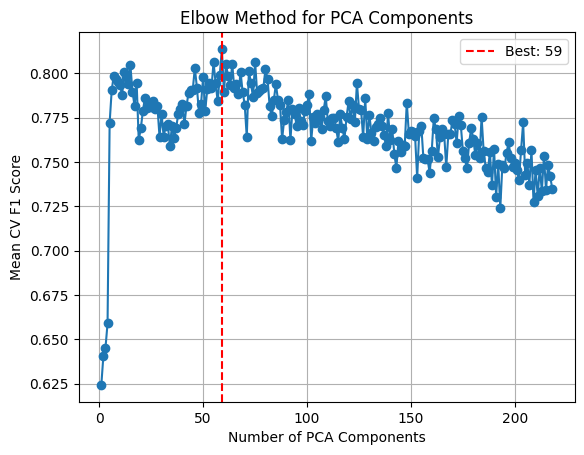

In [84]:
n_components = range(1, X_train.shape[1] + 1)  
f1_scores = []

for n in n_components:
    pipeline = Pipeline([ 
        ('pca', PCA(n_components=n, random_state=42)),         
        ('model', RandomForestClassifier(random_state=42)) 
    ])

    scoring = {
        'f1_weighted': make_scorer(f1_score, average='weighted'),
    }

    cv_results = cross_validate(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=False,
        n_jobs=-1
    )

    f1_mean = cv_results['test_f1_weighted'].mean()
    f1_scores.append(f1_mean)

best_n_components_index = np.argmax(f1_scores)
best_n_components = n_components[best_n_components_index]
best_f1 = f1_scores[best_n_components_index]

print(f"Best Number of Components: {best_n_components}")
print(f"Highest Mean CV F1 Score: {best_f1}")

import matplotlib.pyplot as plt

plt.plot(n_components, f1_scores, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean CV F1 Score')
plt.title('Elbow Method for PCA Components')
plt.axvline(x=best_n_components, color='r', linestyle='--', label=f'Best: {best_n_components}')
plt.legend()
plt.grid()
plt.show()

<h3>3.4. Hyperparameter tuning 

In [85]:
pipeline = Pipeline([
    ('pca', PCA(random_state=42, n_components=59)),
    ('model', RandomForestClassifier(random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200, 300],  
    'model__max_depth': [10, 20, None],  
    'model__min_samples_split': [2, 5, 10],  
    'model__min_samples_leaf': [1, 2, 4],  
    'model__max_features': ['sqrt', 'log2', None]  
}

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50, 
    scoring=scoring,
    refit='f1_weighted',  
    cv=cv, 
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Weighted F1 Score (CV):", random_search.best_score_)

mean_cv_recall = random_search.cv_results_['mean_test_recall_weighted'][random_search.best_index_]
mean_cv_precision = random_search.cv_results_['mean_test_precision_weighted'][random_search.best_index_]
mean_cv_accuracy = random_search.cv_results_['mean_test_accuracy'][random_search.best_index_]

print(f"Mean CV Recall: {mean_cv_recall:.4f}")
print(f"Mean CV Precision: {mean_cv_precision:.4f}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.4f}")

best_pipeline = random_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

print(f"F1 Score on Test Data: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall on Test Data: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Precision on Test Data: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Accuracy on Test Data: {accuracy_score(y_test, y_pred):.4f}")


Best Parameters: {'model__n_estimators': 100, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': None, 'model__max_depth': None}
Best Weighted F1 Score (CV): 0.8490694231889467
Mean CV Recall: 0.8461
Mean CV Precision: 0.8557
Mean CV Accuracy: 0.8461
F1 Score on Test Data: 0.8333
Recall on Test Data: 0.8300
Precision on Test Data: 0.8382
Accuracy on Test Data: 0.8300


After tuning, this is the best performance the model has achieved.

<h2>4. SVM

<h3>4.1. Baseline model

In [46]:
model = SVC(random_state=42)

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  
    ('scaler', StandardScaler()), 
    ('model', SVC(random_state=42))  
])

cv_results = cross_validate(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,
    n_jobs=-1  
)

f1_mean = cv_results['test_f1_weighted'].mean()
recall_mean = cv_results['test_recall_weighted'].mean()
precision_mean = cv_results['test_precision_weighted'].mean()
accuracy_mean = cv_results['test_accuracy'].mean()

print("Cross-Validated Mean Scores:")
print(f"F1 Score (Weighted, CV Mean): {f1_mean:.4f}")
print(f"Recall (Weighted, CV Mean): {recall_mean:.4f}")
print(f"Precision (Weighted, CV Mean): {precision_mean:.4f}")
print(f"Accuracy (CV Mean): {accuracy_mean:.4f}")

Cross-Validated Mean Scores:
F1 Score (Weighted, CV Mean): 0.7412
Recall (Weighted, CV Mean): 0.7610
Precision (Weighted, CV Mean): 0.7360
Accuracy (CV Mean): 0.7610


<h3>4. Applying PCA 

Best Number of Components: 49
Highest Mean CV F1 Score: 0.756265486466517


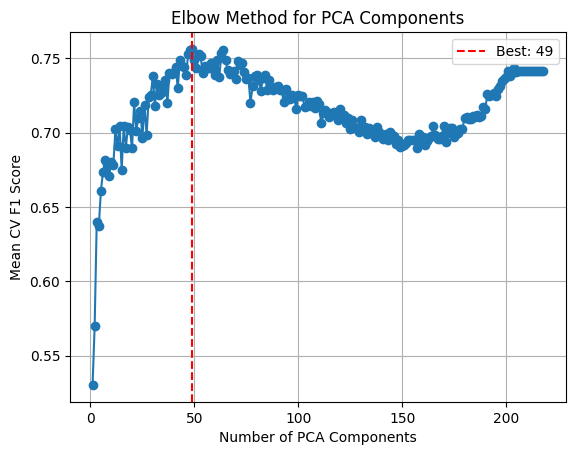

In [ ]:
n_components = range(1, X_train.shape[1] + 1) 
f1_scores = []

for n in n_components:
    pipeline = Pipeline([ 
        ('smote', SMOTE(random_state=42)), 
        ('scaler', StandardScaler()),            
        ('pca', PCA(n_components=n, random_state=42)),         
        ('model', SVC(random_state=42))  
    ])

    scoring = {
        'f1_weighted': make_scorer(f1_score, average='weighted'),
    }

    cv_results = cross_validate(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=False,
        n_jobs=-1
    )

    f1_mean = cv_results['test_f1_weighted'].mean()
    f1_scores.append(f1_mean)

best_n_components_index = np.argmax(f1_scores)
best_n_components = n_components[best_n_components_index]
best_f1 = f1_scores[best_n_components_index]

print(f"Best Number of Components: {best_n_components}")
print(f"Highest Mean CV F1 Score: {best_f1}")

plt.plot(n_components, f1_scores, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean CV F1 Score')
plt.title('Elbow Method for PCA Components')
plt.axvline(x=best_n_components, color='r', linestyle='--', label=f'Best: {best_n_components}')
plt.legend()
plt.grid()
plt.show()

In [95]:
from imblearn.pipeline import Pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42, n_components=49)),
    ('model', SVC(random_state=42))
])

param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'model__gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1_weighted',  
    cv=cv, 
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Weighted F1 Score:", grid_search.best_score_)

mean_cv_recall = grid_search.cv_results_['mean_test_recall_weighted'][grid_search.best_index_]
mean_cv_precision = grid_search.cv_results_['mean_test_precision_weighted'][grid_search.best_index_]
mean_cv_accuracy = grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]

print(f"Mean CV Recall: {mean_cv_recall:.4f}")
print(f"Mean CV Precision: {mean_cv_precision:.4f}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"F1 Score on Test Data: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall on Test Data: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Precision on Test Data: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Accuracy on Test Data: {accuracy_score(y_test, y_pred):.4f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best Weighted F1 Score: 0.756265486466517
Mean CV Recall: 0.7547
Mean CV Precision: 0.7594
Mean CV Accuracy: 0.7547
F1 Score on Test Data: 0.6939
Recall on Test Data: 0.6950
Precision on Test Data: 0.6928
Accuracy on Test Data: 0.6950


After tuning, this is the best performance the model has achieved.

<h2>5. Light GBM

<h3>5.1. Baseline model

In [51]:
model = LGBMClassifier(random_state=42, verbosity=-1)

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=42)), 
    ('model', LGBMClassifier(random_state=42, verbosity=-1))  
])

cv_results = cross_validate(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,
    n_jobs=-1  
)

f1_mean = cv_results['test_f1_weighted'].mean()
recall_mean = cv_results['test_recall_weighted'].mean()
precision_mean = cv_results['test_precision_weighted'].mean()
accuracy_mean = cv_results['test_accuracy'].mean()

print("Cross-Validated Mean Scores:")
print(f"F1 Score (Weighted, CV Mean): {f1_mean:.4f}")
print(f"Recall (Weighted, CV Mean): {recall_mean:.4f}")
print(f"Precision (Weighted, CV Mean): {precision_mean:.4f}")
print(f"Accuracy (CV Mean): {accuracy_mean:.4f}")

Cross-Validated Mean Scores:
F1 Score (Weighted, CV Mean): 0.8564
Recall (Weighted, CV Mean): 0.8573
Precision (Weighted, CV Mean): 0.8599
Accuracy (CV Mean): 0.8573


<h3>5.2 Applying PCA 

Best Number of Components: 43
Highest Mean CV F1 Score: 0.8512301513435562


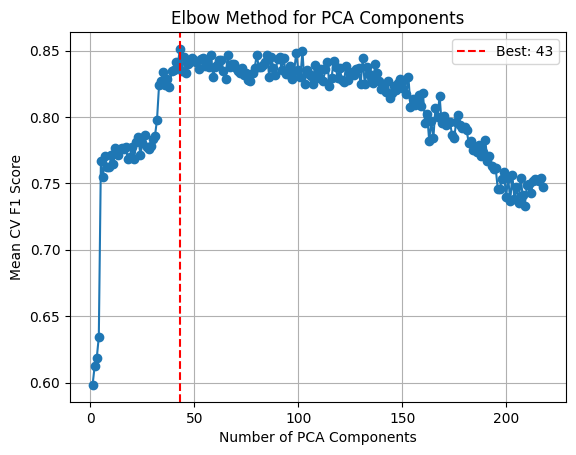

In [93]:
n_components = range(1, X_train.shape[1] + 1) 
f1_scores = []

for n in n_components:
    pipeline = Pipeline([ ('smote', SMOTETomek(random_state=42)),             
        ('pca', PCA(n_components=n, random_state=42)),         
        ('model', LGBMClassifier(random_state=42))  
    ])

    scoring = {
        'f1_weighted': make_scorer(f1_score, average='weighted'),
    }

    cv_results = cross_validate(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=False,
        n_jobs=-1
    )

    f1_mean = cv_results['test_f1_weighted'].mean()
    f1_scores.append(f1_mean)

best_n_components_index = np.argmax(f1_scores)
best_n_components = n_components[best_n_components_index]
best_f1 = f1_scores[best_n_components_index]

print(f"Best Number of Components: {best_n_components}")
print(f"Highest Mean CV F1 Score: {best_f1}")

plt.plot(n_components, f1_scores, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean CV F1 Score')
plt.title('Elbow Method for PCA Components')
plt.axvline(x=best_n_components, color='r', linestyle='--', label=f'Best: {best_n_components}')
plt.legend()
plt.grid()
plt.show()

<h3>5.3. Hyperparameter tuning 

In [96]:
pipeline = Pipeline([
    ('smote', SMOTETomek(random_state=42)),             
    ('pca', PCA(n_components=43, random_state=42)),         
    ('model', LGBMClassifier(random_state=42))  
])

param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7]
}

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,  
    refit='f1_weighted',  
    cv=cv,  
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Weighted F1 Score:", grid_search.best_score_)

mean_cv_recall = grid_search.cv_results_['mean_test_recall_weighted'][grid_search.best_index_]
mean_cv_precision = grid_search.cv_results_['mean_test_precision_weighted'][grid_search.best_index_]
mean_cv_accuracy = grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]

print(f"Mean CV Recall: {mean_cv_recall:.4f}")
print(f"Mean CV Precision: {mean_cv_precision:.4f}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"F1 Score on Test Data: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall on Test Data: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Precision on Test Data: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Accuracy on Test Data: {accuracy_score(y_test, y_pred):.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Number of positive: 594, number of negative: 594
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10965
[LightGBM] [Info] Number of data points in the train set: 1188, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

After tuning, this is the best performance the model has achieved.

<h2>6. XGBoost

<h3>6.1. Baseline model

In [54]:
model = XGBClassifier()

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

cv_results = cross_validate(
    estimator=model,
    X=X_train,
    y=y_train,
    scoring=scoring,
    cv=cv,
    return_train_score=False,
    n_jobs=-1 
)

f1_mean = cv_results['test_f1_weighted'].mean()
recall_mean = cv_results['test_recall_weighted'].mean()
precision_mean = cv_results['test_precision_weighted'].mean()
accuracy_mean = cv_results['test_accuracy'].mean()

print("Cross-Validated Mean Scores:")
print(f"F1 Score (Weighted, CV Mean): {f1_mean:.4f}")
print(f"Recall (Weighted, CV Mean): {recall_mean:.4f}")
print(f"Precision (Weighted, CV Mean): {precision_mean:.4f}")
print(f"Accuracy (CV Mean): {accuracy_mean:.4f}")

Cross-Validated Mean Scores:
F1 Score (Weighted, CV Mean): 0.8428
Recall (Weighted, CV Mean): 0.8436
Precision (Weighted, CV Mean): 0.8464
Accuracy (CV Mean): 0.8436


<h3>6.2. Applying PCA 

Best Number of Components: 164
Highest Mean CV F1 Score: 0.8631264439732652


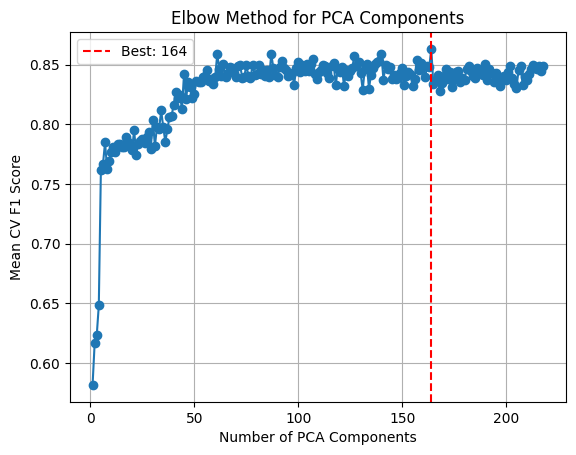

In [106]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
n_components = range(1, X_train.shape[1] + 1) 
f1_scores = []

for n in n_components:
    pipeline = Pipeline([ 
        ('pca', PCA(n_components=n, random_state=42)),         
        ('model', XGBClassifier(random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False))  
    ])

    scoring = {
        'f1_weighted': make_scorer(f1_score, average='weighted'),
    }

    cv_results = cross_validate(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        scoring=scoring,
        cv=cv,
        return_train_score=False,
        n_jobs=-1
    )

    f1_mean = cv_results['test_f1_weighted'].mean()
    f1_scores.append(f1_mean)

best_n_components_index = np.argmax(f1_scores)
best_n_components = n_components[best_n_components_index]
best_f1 = f1_scores[best_n_components_index]

print(f"Best Number of Components: {best_n_components}")
print(f"Highest Mean CV F1 Score: {best_f1}")

import matplotlib.pyplot as plt

plt.plot(n_components, f1_scores, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean CV F1 Score')
plt.title('Elbow Method for PCA Components')
plt.axvline(x=best_n_components, color='r', linestyle='--', label=f'Best: {best_n_components}')
plt.legend()
plt.grid()
plt.show()

<h3>6.3. Hyperparameter tuning 

In [107]:
import warnings
warnings.filterwarnings('ignore')  

pipeline = Pipeline([
        ('pca', PCA(n_components=164, random_state=42)),         
        ('model', XGBClassifier(random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False))  
])

param_grid = {
    'model__n_estimators': [50, 100, 200],       
    'model__learning_rate': [0.01, 0.1, 0.3],   
    'model__max_depth': [3, 5, 7],               
    'model__subsample': [0.6, 0.8, 1.0],         
    'model__colsample_bytree': [0.6, 0.8, 1.0],  
}

scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'accuracy': 'accuracy'
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring, 
    refit='f1_weighted',  
    cv=cv,                  
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print(f"Best F1 Score (Weighted, CV Mean): {best_score:.4f}")

mean_cv_recall = grid_search.cv_results_['mean_test_recall_weighted'][grid_search.best_index_]
mean_cv_precision = grid_search.cv_results_['mean_test_precision_weighted'][grid_search.best_index_]
mean_cv_accuracy = grid_search.cv_results_['mean_test_accuracy'][grid_search.best_index_]

print(f"Mean CV Recall: {mean_cv_recall:.4f}")
print(f"Mean CV Precision: {mean_cv_precision:.4f}")
print(f"Mean CV Accuracy: {mean_cv_accuracy:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"F1 Score on Test Data: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall on Test Data: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Precision on Test Data: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Accuracy on Test Data: {accuracy_score(y_test, y_pred):.4f}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 50, 'model__subsample': 1.0}
Best F1 Score (Weighted, CV Mean): 0.8632
Mean CV Recall: 0.8586
Mean CV Precision: 0.8757
Mean CV Accuracy: 0.8586
F1 Score on Test Data: 0.8470
Recall on Test Data: 0.8400
Precision on Test Data: 0.8653
Accuracy on Test Data: 0.8400


After tuning, this is the best performance the model has achieved.

<h1> VI. Comparision 

<h2>1. Comparison between models with and without PCA (Decision Tree and Random Forest)

In [2]:
data = {
    "Model": [
        "Decision Tree (PCA)", 
        "Decision Tree (Without PCA)", 
        "Random Forest (PCA)", 
        "Random Forest (Without PCA)"
    ],
    "F1 Mean CV": [0.8369133786, 0.8691, 0.8490694232, 0.8608],
    "Recall Mean CV": [0.8311, 0.8636, 0.8461, 0.8586],
    "Precision Mean CV": [0.8544, 0.8873, 0.8557, 0.8706],
    "Accuracy Mean CV": [0.8311, 0.8636, 0.8461, 0.8586],
    "F1 Test": [0.8431, 0.847, 0.8333, 0.8201],
    "Recall Test": [0.835, 0.84, 0.83, 0.815],
}

df = pd.DataFrame(data)
df

,Model,F1 Mean CV,Recall Mean CV,Precision Mean CV,Accuracy Mean CV,F1 Test,Recall Test
0,Decision Tree (PCA),0.836913,0.8311,0.8544,0.8311,0.8431,0.835
1,Decision Tree (Without PCA),0.869100,0.8636,0.8873,0.8636,0.8470,0.840
2,Random Forest (PCA),0.849069,0.8461,0.8557,0.8461,0.8333,0.830
3,Random Forest (Without PCA),0.860800,0.8586,0.8706,0.8586,0.8201,0.815


<h2>2. Performance Comparison of Models Using PCA

In [104]:
data = {
    "Model": ["Logreg", "Decision Tree", "Random Forest", "SVM", "Light GBM", "XGBoost"],
    "F1 Mean CV": [0.7900999902, 0.8369133786, 0.8490694232, 0.7562654865, 0.8491887713, 0.8632],
    "Recall Mean CV": [0.7900999902, 0.8311, 0.8461, 0.7547, 0.8436, 0.8586],
    "Precision Mean CV": [0.7992, 0.8544, 0.8557, 0.7594, 0.8652, 0.8758],
    "Accuracy Mean CV": [0.7848, 0.8311, 0.8461, 0.7547, 0.8436, 0.8586],
    "F1 Test": [0.7731, 0.8431, 0.8333, 0.6939, 0.8315, 0.8508],
    "Recall Test": [0.77, 0.835, 0.83, 0.695, 0.825, 0.845]
}

df = pd.DataFrame(data)
df

,Model,F1 Mean CV,Recall Mean CV,Precision Mean CV,Accuracy Mean CV,F1 Test,Recall Test
0,Logreg,0.790100,0.7901,0.7992,0.7848,0.7731,0.770
1,Decision Tree,0.836913,0.8311,0.8544,0.8311,0.8431,0.835
2,Random Forest,0.849069,0.8461,0.8557,0.8461,0.8333,0.830
3,SVM,0.756265,0.7547,0.7594,0.7547,0.6939,0.695
4,Light GBM,0.849189,0.8436,0.8652,0.8436,0.8315,0.825
5,XGBoost,0.863200,0.8586,0.8758,0.8586,0.8508,0.845


The comparison highlights that XGBoost outperforms the other models, achieving the highest F1 score and Recall in both cross-validation (CV) and test datasets. This indicates that XGBoost is the most effective model at balancing precision and recall while correctly identifying positive samples, making it the best choice for this particular dataset and problem.

However, it’s worth noting that Light GBM comes very close in performance, particularly in the test set, which suggests it could also be a viable alternative, especially if computational efficiency is a concern.

<h1>VII. Conclusion 

Yes, there is a trade-off when using PCA with a high fraction of variance (e.g., 0.99):

The Trade-Off in PCA
Higher Fraction of Variance (e.g., 0.99):

Pros:
Retains almost all the information in the dataset, minimizing the risk of losing important features.
Ensures the model has access to the maximum amount of variability in the data.
Cons:
Retains more principal components, which may result in higher computational cost.
If the dataset has noise, it may also retain that noise, potentially reducing model performance.
Lower Fraction of Variance (e.g., 0.8 or 0.9):

Pros:
Reduces the number of features significantly, leading to faster computation and potentially simpler models.
May eliminate noise, improving model generalization.
Cons:
Risk of losing some important variability or information from the dataset, which could hurt model performance.
How the Trade-Off Applies Here
By choosing n_components=0.99, you're prioritizing retaining as much information as possible, which may be beneficial if your dataset contains highly informative features. However, this could lead to a higher number of retained features, making the model more complex and potentially less efficient.
If you notice that retaining 0.99 variance yields diminishing returns on metrics like F1-score or accuracy, you could experiment with lower fractions (e.g., 0.95 or 0.9) to strike a better balance between model simplicity and performance.